# Setup môi trường

In [1]:
import os
print(os.getcwd())
os.chdir("../../..")
print(os.getcwd())

/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase2_280824/notebooks/train_module2/without_aug_data
/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase2_280824


In [12]:
import torch
from src.models.module2.ann import ANN

model = ANN(input_dim=39, output_dim=3, num_hidden=9, num_layers=3, dropout=0.5)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

570


# Setup data

In [4]:
import pandas as pd

# Đọc dữ liệu từ CSV
data_dir = './data/processed/'
train_df = pd.read_csv(data_dir + 'train_features.csv').drop(columns=['image_path'])
valid_df = pd.read_csv(data_dir + 'valid_features.csv').drop(columns=['image_path'])
test_df = pd.read_csv(data_dir + 'test_features.csv').drop(columns=['image_path'])

# data_dir = './data/augmented/'
# train_df_aug = pd.read_csv(data_dir + 'train_augmented_features.csv')

# Xem cấu trúc của DataFrame
print('Train DataFrame:')
print(train_df.head(3))
print('Valid DataFrame:')
print(valid_df.head(3))
print('Test DataFrame:')
print(test_df.head(3))
# print('Train Augmented DataFrame:')
# print(train_df_aug.head(3))

Train DataFrame:
   label     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0      2  1.518592 -2.122206  1.063359  1.083591 -3.078244  1.832143   
1      2 -3.997844 -2.013066  5.606269 -2.221863  0.908517  0.995050   
2      2 -4.144322 -3.335181  7.014940 -2.851661 -1.254374  4.090703   

      dim_6     dim_7     dim_8  ...    dim_29    dim_30    dim_31    dim_32  \
0 -3.617894  1.835063  0.739837  ... -0.450482  0.230301  0.322319 -0.361697   
1 -4.953275  1.075495  3.199515  ...  2.695855 -4.411282 -1.748895  5.605376   
2 -3.888599 -2.345787  6.091836  ...  6.469357 -5.430499 -2.013651  6.954945   

     dim_33    dim_34    dim_35    dim_36    dim_37    dim_38  
0 -1.096648  1.402599  0.442939 -3.928780  2.343227  1.505659  
1 -6.375985 -0.828269  6.179725 -4.965612  0.590781  3.893331  
2 -3.220028 -1.721707  5.068684 -4.063029 -1.196603  5.176606  

[3 rows x 40 columns]
Valid DataFrame:
   label     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0    

In [5]:
import torch
# Tính toán số lượng mẫu của mỗi lớp
class_counts = train_df['label'].value_counts()
total_samples = len(train_df)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

# In ra thông tin trọng số
print("Class Weights (inverse frequency):")
print(class_weights)

# Chuyển đổi trọng số nhãn thành tensor
class_weights_tensor = torch.tensor(sorted(list(class_weights.values()), reverse=True), dtype=torch.float)
print(class_weights_tensor)

Class Weights (inverse frequency):
{2: 0.7698412698412699, 1: 1.1119929453262787, 0: 1.2472799208704253}
tensor([1.2473, 1.1120, 0.7698])


In [6]:
from torch.utils.data import DataLoader, TensorDataset

# Chia dữ liệu thành các tensor
X_train = torch.tensor(train_df.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 39)
y_train = torch.tensor(train_df['label'].values, dtype=torch.long)
X_valid = torch.tensor(valid_df.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 39)
y_valid = torch.tensor(valid_df['label'].values, dtype=torch.long)
X_test = torch.tensor(test_df.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 39)
y_test = torch.tensor(test_df['label'].values, dtype=torch.long)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

# Tạo DataLoader
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=120, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=120, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=120, shuffle=False)

torch.Size([1261, 39]) torch.Size([1261])
torch.Size([270, 39]) torch.Size([270])
torch.Size([273, 39]) torch.Size([273])


# Huấn luyện mô hình

In [13]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# set seed
torch.manual_seed(97)

model.to('cuda')
criterion.to('cuda')

num_epochs = 300
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Đánh giá mô hình trên tập validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss:.4f}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_ANN_withoutAug.pth')

Epoch 1/300, Train Loss: 1.1509, Validation Loss: 1.1182
Epoch 2/300, Train Loss: 1.1484, Validation Loss: 1.1139
Epoch 3/300, Train Loss: 1.1458, Validation Loss: 1.1095
Epoch 4/300, Train Loss: 1.1431, Validation Loss: 1.1051
Epoch 5/300, Train Loss: 1.1414, Validation Loss: 1.1015
Epoch 6/300, Train Loss: 1.1391, Validation Loss: 1.0979
Epoch 7/300, Train Loss: 1.1365, Validation Loss: 1.0940
Epoch 8/300, Train Loss: 1.1333, Validation Loss: 1.0904
Epoch 9/300, Train Loss: 1.1311, Validation Loss: 1.0869
Epoch 10/300, Train Loss: 1.1288, Validation Loss: 1.0833
Epoch 11/300, Train Loss: 1.1265, Validation Loss: 1.0797
Epoch 12/300, Train Loss: 1.1230, Validation Loss: 1.0761
Epoch 13/300, Train Loss: 1.1196, Validation Loss: 1.0730
Epoch 14/300, Train Loss: 1.1154, Validation Loss: 1.0698
Epoch 15/300, Train Loss: 1.1110, Validation Loss: 1.0663
Epoch 16/300, Train Loss: 1.1065, Validation Loss: 1.0621
Epoch 17/300, Train Loss: 1.1020, Validation Loss: 1.0583
Epoch 18/300, Train Los

# Kiểm thử

## Trên tập valid


AUC Scores for each class:
0.9505273342721902

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.74      0.85      0.79        81
           2       0.88      0.78      0.83       117

    accuracy                           0.86       270
   macro avg       0.86      0.87      0.86       270
weighted avg       0.86      0.86      0.86       270



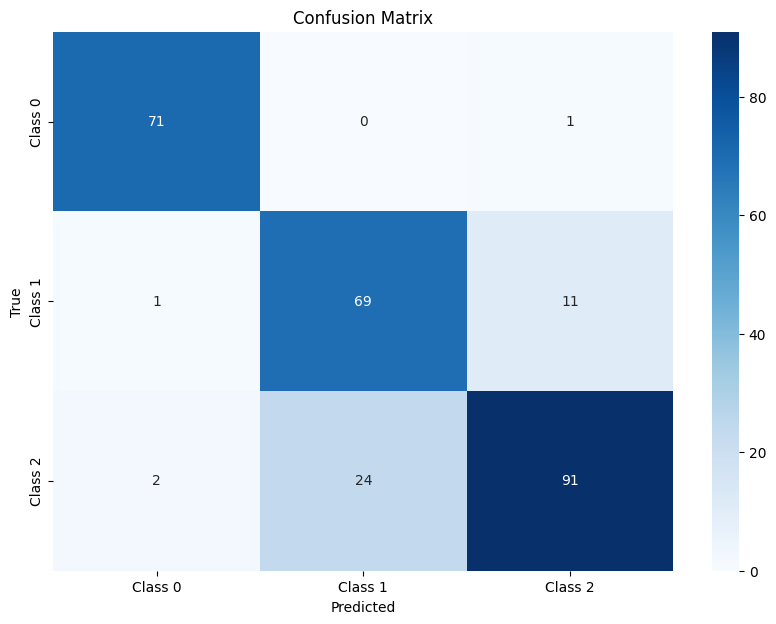

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_ANN_withoutAug.pth', weights_only=True, map_location='cpu'))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_prob.extend(prob.cpu().numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Trên tập test


AUC Scores for each class:
0.9423654605284476

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        73
           1       0.69      0.91      0.79        82
           2       0.93      0.76      0.84       118

    accuracy                           0.85       273
   macro avg       0.87      0.87      0.86       273
weighted avg       0.88      0.85      0.85       273



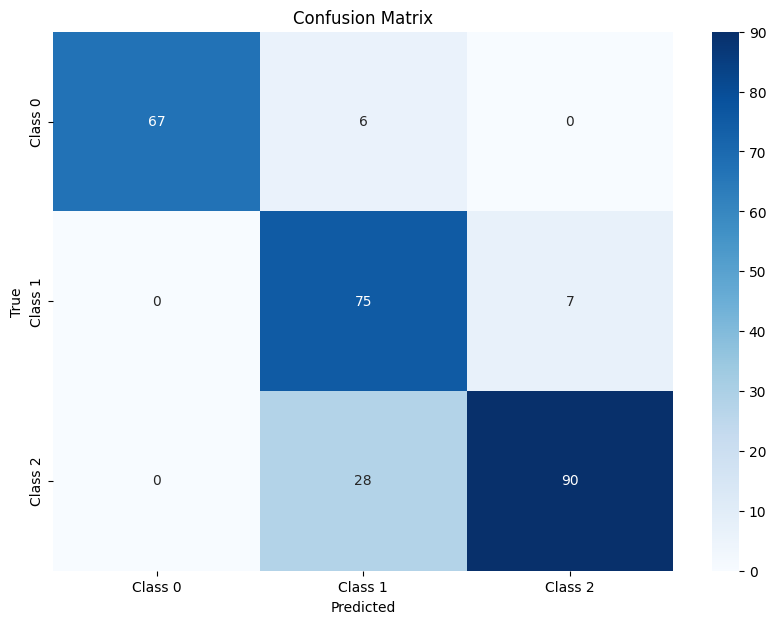

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_ANN_withoutAug.pth', weights_only=True, map_location='cpu'))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_prob.extend(prob.cpu().numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()